In [24]:
import skimage
import scipy
import os
from skimage import io,img_as_float,img_as_uint
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from sklearn.ensemble import RandomForestClassifier as RFC
from datetime import datetime
from scipy import ndimage
import pickle
import imagelibs.tmml as tmml
print(scipy.__version__)
print(skimage.__version__)
import sklearn
print(sklearn.__version__)
print(np.__version__)

1.4.1
0.16.2
0.22.1
1.18.1


In [25]:
#a helper function for displaying
def trim_axs(axs, N):
    """little helper to massage the axs list to have correct length..."""
    axs = axs.flat
    for ax in axs[N:]:
        ax.remove()
    return axs[:N]

## Let's use the features to do pixel classification!

features(128, 128, 60)


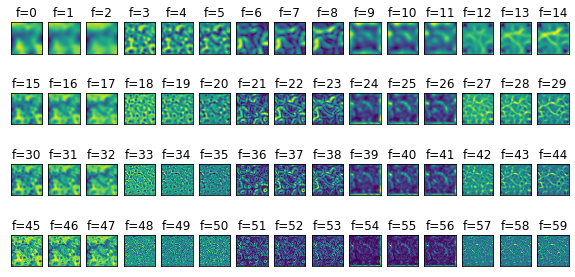

In [3]:
#location of the seeds to train
location="/home/Documents/seeds/"
#where to save results
savelocation="/home/Documents/examples/"
#which are the label images
seedimg=img_as_float(io.imread(location+"squarePatches/seeds/seed80.png"))
#which are the tissue images from which features will be extracted
rgbimg=img_as_float(io.imread(location+"squarePatches/rgb/rgb80.png"))

sigmas=[10.0,5.0,3.5,1.6,None] 
slen=len(sigmas)

#crete the first features for the first sigma
patchFeatures=tmml.getFeatures(rgbimg,sigmas[0],s2=sigmas[1])
for s in range(1,slen-1):
    features=tmml.getFeatures(rgbimg,sigmas[s],s2=sigmas[s+1])
    patchFeatures=np.concatenate((patchFeatures,features),axis=-1)

print("features"+str(patchFeatures.shape))

fig, axs = plt.subplots(4,15, figsize=(10,5))
axs = trim_axs(axs, patchFeatures.shape[2])
for ax, f in zip(axs, range(patchFeatures.shape[2])):
    ax.set_title('f=%s' % str(f))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(patchFeatures[...,f])
plt.show()


### These are for the cores of size highest minus 1 (5000x5000) approx
#### get the features in order to train

In [26]:
## Load all images, and accumulate features np.where there is a label in the image, check for balanced labels
noncan=25 #non cancer
cancer=50 #cancer
backgr=75 # background
classes=[noncan,cancer,backgr]
numclasses=len(classes)
imsize=128
padding=20
allfs=[np.ones((60,1),dtype="float16"),np.ones((60,1),dtype="float16"),np.ones((60,1),dtype="float16")]

location="/home/Documents/seeds/"
savelocation="/home/Documents/examples/"
sigmas=[10.0,5.0,3.5,1.6,None] 

numimages=805
for i in range(numimages):
    seedimg=io.imread(location+"squarePatches/seeds/seed"+str(i)+".png")
    rgbimg=img_as_float(io.imread(location+"squarePatches/rgb/rgb"+str(i)+".png"))
        
    slen=len(sigmas)

    #crete the first features for the first sigma
    patchFeatures=tmml.getFeatures(rgbimg,sigmas[0],s2=sigmas[1])
    for s in range(1,slen-1):
        features=tmml.getFeatures(rgbimg,sigmas[s],s2=sigmas[s+1])
        patchFeatures=np.concatenate((patchFeatures,features),axis=-1)
        
    ##avoid borders by cropping
    seedimg=seedimg[padding:-padding,padding:-padding]
    rgbimg=rgbimg[padding:-padding,padding:-padding,:]
    patchFeatures=patchFeatures[padding:-padding,padding:-padding,:]
    
    for ci in range(numclasses):
        c=classes[ci]
        #print(c)
        #find np.where there is this class in the seed
        imgidx=np.where(seedimg==c) #this should return a 2xN array or coordinates
        if(len(imgidx[0])!=0 and len(imgidx[0])!=0):
            if(allfs[ci].shape[1]==1):
                allfs[ci]=patchFeatures[imgidx].T
            else:
                allfs[ci]=np.concatenate((allfs[ci],patchFeatures[imgidx].T),axis=-1)

               

In [30]:
cl25=allfs[0]
cl50=allfs[1]
cl75=allfs[2]

print(cl25.shape)
print(cl50.shape)
print(cl75.shape)

(60, 642712)
(60, 885819)
(60, 116644)


#### If you want to augment background

In [7]:
#get equal amounts
minamount=np.minimum(cl75.shape[1],np.minimum(cl25.shape[1],cl50.shape[1]))
print(minamount)

ind25=np.random.choice(cl25.shape[1], minamount)
ind50=np.random.choice(cl50.shape[1], minamount)
ind75=np.random.choice(cl75.shape[1], minamount)

cl25=cl25[:,ind25]
cl50=cl50[:,ind50]
cl75=cl75[:,ind75]

print(cl25.shape)
print(cl50.shape)
print(cl75.shape)

116644
(60, 116644)
(60, 116644)
(60, 116644)


### prepare this data for sklearn random forests

In [31]:
y25=np.ones(cl25.shape[1],dtype="int8")*1
y50=np.ones(cl50.shape[1],dtype="int8")*2
y75=np.ones(cl75.shape[1],dtype="int8")*3
print(y25.shape)
print(y50.shape)
print(y75.shape)

(642712,)
(885819,)
(116644,)


In [32]:
allnall=np.concatenate((cl25,cl50,cl75),axis=-1)
yall=np.concatenate((y25,y50,y75),axis=-1)
print(allnall.shape)
print(yall.shape)
allnall=np.swapaxes(allnall,0,1)
print(allnall.shape)
allnall=allnall.astype("float16")
print(allnall.dtype)
print(yall.dtype)

(60, 1645175)
(1645175,)
(1645175, 60)
float16
int8


In [ ]:
help(RFC)

In [33]:
clf=RFC(warm_start=True,n_estimators=100)

In [35]:
now = datetime.now()
print("now =", now)

clf.fit(allnall,yall)

now2 = datetime.now()
print("now2 =", now2)
print("Fitting took =", now2-now)

now = 2020-03-04 20:02:27.157013
now2 = 2020-03-04 20:24:02.885448
Fitting took = 0:21:35.728435


In [36]:
#model for fullsize -1
filename = '/home/Documents/models/clf5000-allfeats.sav'

In [37]:
pickle.dump(clf, open(filename, 'wb'))

In [15]:
# some time later...
 
# load the model from disk
clf = pickle.load(open(filename, 'rb'))

In [ ]:
dir(clf)

## Predict usring the random forest model

In [38]:
now = datetime.now()
print("started =", now)

location="/home/Documents/HiResStudy/RGB/"
savelocation="/home/Documents/HiResStudy/RFseg/"

#put all your cores here or list them 
allrgbcores=os.listdir(location)

iformat=".png"
#seedimg=io.imread("/home/leslie/Documents/Uppsala/portugalDataset/carla/16seeds/CD44v6_5_region51-SEEDS.png")
#print(seedimg.shape)
sigmas=[10.0,5.0,3.5,1.6,None] 
slen=len(sigmas)
for i in range(len(allrgbcores)):
    rgbimg=io.imread(location+allrgbcores[i]+iformat)

    # seedimg[0,0]=0
    # seedimg[0,1]=25
    # seedimg[0,2]=50
    # seedimg[0,3]=75

    #crete the first features for the first sigma
    patchFeatures=tmml.getFeatures(rgbimg,sigmas[0],s2=sigmas[1])
    #now for the rest
    for s in range(1,slen-1):
        features=tmml.getFeatures(rgbimg,sigmas[s],s2=sigmas[s+1])
        patchFeatures=np.concatenate((patchFeatures,features),axis=-1)

    
    #print(""+str(patchFeatures.shape))
    rgbimg=0
    w=patchFeatures.shape[1]
    h=patchFeatures.shape[0]

    print(w,h)

    patchFeatures=np.reshape(patchFeatures,(w*h,60))

    print("features"+str(patchFeatures.shape))

    #I NEED TO KNOW IF I HAVE TO FLIP THIS!!!! BECAUSE I TRANSPOSED DURING TRAINING
    #Apparently NO, I dont need to flip anything

    now2 = datetime.now()
    print("finished features for "+allrgbcores[i]+" = ", now2)
    print("features took =", now2-now)
    
    now = datetime.now()
    print("started prediction=", now)

    pred=clf.predict(patchFeatures)

    now2 = datetime.now()
    print("finished prediction for "+allrgbcores[i]+" = ",  now2)
    print("pred took =", now2-now)
    
    pred=np.reshape(pred,(h,w))
    pred*=85
    pred.shape
    
    io.imsave(savelocation+allrgbcores[i]+"_RFallfeats.png",pred.astype("uint8"))

started = 2020-03-04 20:24:04.239673
4457 4614
features(20564598, 60)
finished features for CD44v6_1_B_RGB_region1 =  2020-03-04 20:26:24.313040
features took = 0:02:20.073367
started prediction= 2020-03-04 20:26:24.337030
finished prediction for CD44v6_1_B_RGB_region1 =  2020-03-04 20:28:54.592134
pred took = 0:02:30.255104
4534 4983
features(22592922, 60)
finished features for CD44v6_1_B_RGB_region3 =  2020-03-04 20:31:24.775835
features took = 0:05:00.438805
started prediction= 2020-03-04 20:31:24.802134
finished prediction for CD44v6_1_B_RGB_region3 =  2020-03-04 20:34:18.470852
pred took = 0:02:53.668718
4838 4567
features(22095146, 60)
finished features for CD44v6_1_B_RGB_region4 =  2020-03-04 20:36:44.182771
features took = 0:05:19.380637
started prediction= 2020-03-04 20:36:44.184677
finished prediction for CD44v6_1_B_RGB_region4 =  2020-03-04 20:39:18.772952
pred took = 0:02:34.588275


### For one core

In [ ]:
pred=clf.predict(patchFeatures)

In [ ]:
pred=np.reshape(pred,(h,w))
pred*=25
pred.shape
#put 4 pixels of the right colors
pred[0,0]=0;pred[0,1]=25;pred[0,2]=50
pred[0,3]=75;pred[0,4]=255

In [ ]:
%matplotlib notebook
fig, axs = plt.subplots(1,3, figsize=(9,4))
axs[0].imshow(rgbimg)
axs[0].imshow(pred,cmap="gist_rainbow",alpha=0.4)
axs[1].imshow(seedimg,cmap="gray")
axs[2].imshow(pred,cmap="gray")
plt.show()

In [ ]:
io.imsave(savelocation+"CD44v6_5_region51-RFclass.png",pred.astype("uint8"))